# <font size="7">Libs</font>

In [1]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
print('torch version (<2): ', torch.__version__)

import ptls
from ptls.frames import PtlsDataModule
from ptls.frames.coles import losses, sampling_strategies
from ptls.frames.coles import split_strategy

from ptls.nn.seq_encoder import agg_feature_seq_encoder
from ptls.nn import RnnSeqEncoder, TrxEncoder, Head
from ptls.nn.seq_encoder.agg_feature_seq_encoder import AggFeatureSeqEncoder

from ptls.data_load.datasets import AugmentationDataset, MemoryMapDataset
from ptls.data_load.augmentations import AllTimeShuffle, DropoutTrx
from ptls.data_load.datasets.parquet_dataset import ParquetDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.data_load.datasets import parquet_file_scan
from ptls.data_load.datasets import ParquetDataset, ParquetFiles, AugmentationDataset
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter
from ptls.data_load.augmentations import DropoutTrx
from ptls.data_load.datasets import inference_data_loader

from functools import partial

import pytorch_lightning as pl

import lightgbm as lgb

import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/home/jovyan/conda/ptls/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version (<2):  1.12.1+cu102


In [2]:
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()

<Figure size 800x600 with 0 Axes>

# <font size="7">Data Module</font>

In [3]:
data_module = PtlsDataModule(
    train_data=ptls.frames.coles.ColesDataset(
        splitter=split_strategy.SampleSlices(split_count=5, cnt_min=15, cnt_max=150),
        data=ptls.data_load.datasets.AugmentationDataset(
            data=MemoryMapDataset(
                data=ParquetDataset(
                    i_filters=[SeqLenFilter(min_seq_len=25), FeatureFilter()],
                    data_files=parquet_file_scan(file_path='src/ptls-experiments/scenario_rosbank/data/train_trx.parquet',
                                                 valid_rate=0.05,
                                                 return_part='train')
                )
            ),
            f_augmentations=[ptls.data_load.augmentations.DropoutTrx(trx_dropout=0.01)]
        )
    ),
    train_batch_size=128,
    train_num_workers=8,
    
    valid_data=ptls.frames.coles.ColesDataset(
        splitter=split_strategy.SampleSlices(split_count=5, cnt_min=15, cnt_max=75),
        data=MemoryMapDataset(
            data=ParquetDataset(
                i_filters=[FeatureFilter()],
                data_files=parquet_file_scan(file_path='src/ptls-experiments/scenario_rosbank/data/train_trx.parquet',
                                                 valid_rate=0.05, 
                                                 return_part='valid')
            )
        )
    ),
    valid_batch_size=256,
    valid_num_workers=16,
)

# <font size="7">Model</font>

# <font size="6">Loss Block</font>

In [4]:
import torch
from torch import nn as nn
from torch.nn import functional as F

CONTRASTIVE_LOSS = []

class L2NormEncoder(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.eps = eps

    def forward(self, x: torch.Tensor):
        return x / (x.pow(2).sum(dim=-1, keepdim=True) + self.eps).pow(0.5)

class ContrastiveLoss(nn.Module):
    """
    Contrastive loss

    "Signature verification using a siamese time delay neural network", NIPS 1993
    https://papers.nips.cc/paper/769-signature-verification-using-a-siamese-time-delay-neural-network.pdf
    """

    def __init__(self, margin, sampling_strategy):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = sampling_strategy
        
        self.norm = L2NormEncoder()
        self.batchnorm = nn.BatchNorm1d(1024, affine=True)
    
    def forward(self, embeddings, target):
        embeddings = self.norm(embeddings)
#         embeddings = self.batchnorm(embeddings)
        
        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        positive_loss = F.pairwise_distance(embeddings[positive_pairs[:, 0]], embeddings[positive_pairs[:, 1]]).pow(2)
        negative_loss = F.relu(
            self.margin - F.pairwise_distance(embeddings[negative_pairs[:, 0]], embeddings[negative_pairs[:, 1]])
        ).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)
        
        global CONTRASTIVE_LOSS
        CONTRASTIVE_LOSS.append(loss.sum())
        
        return loss.sum()

In [5]:
VAR_OF_EMBEDDINGS = []
STD_LOSS = []
COVATIANCE_LOSS = []


class VICRegLoss(nn.Module):
    
    def __init__(self, ):
        super(VICRegLoss, self).__init__()
        
        self._agg_encoder = AggFeatureSeqEncoder(         
            embeddings={
                "mcc": {"in": 100},
                "channel_type": {"in": 4},
                "currency": {"in": 4},
                "trx_category": {"in": 10}
            },

            numeric_values={
                'amount': 'identity',
            },
     
            was_logified=True,  
            log_scale_factor=1
        )
        self.instanceNorm = nn.InstanceNorm1d(362, affine=True)
        self.batchnorm = nn.BatchNorm1d(1024, affine=True)
        self.norm = L2NormEncoder()
        
    def forward(self, embeddings, aggs):
#         embeddings = self.batchnorm(embeddings)
        #|--------------------------------------------------------|
        aggs = self._agg_encoder(aggs)
        aggs = self.instanceNorm(aggs.view(362, len(aggs)))
        
        cov_aggs_embs = (aggs @ embeddings) / 640
        cov_loss = cov_aggs_embs.pow_(2).sum()
        
        std_embeddings = torch.sqrt(embeddings.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_embeddings))

        global VAR_OF_EMBEDDINGS, STD_LOSS, COVATIANCE_LOSS
        VAR_OF_EMBEDDINGS.append(std_embeddings)
        STD_LOSS.append(std_loss)
        COVATIANCE_LOSS.append(cov_loss)
        
        return [cov_loss, std_loss] 

In [36]:
class Loss(nn.Module):
    def __init__(self, contrastiveLoss, vicregLoss):
        super(Loss, self).__init__()
        
        self.contrastiveLoss = contrastiveLoss
        self.vicregLoss = vicregLoss
        
    def forward(self, embeddings, target, aggs):
        
        losses = self.vicregLoss(embeddings, aggs)
        cov_loss = losses[0]
        std_loss = losses[1]
        con_loss = self.contrastiveLoss.forward(embeddings, target)
        
        return [[con_loss, cov_loss, std_loss], 0.55 * con_loss + cov_loss + std_loss]

# <font size="6">ABS Module</font>

In [37]:
import torch
import pytorch_lightning as pl
from ptls.data_load.padded_batch import PaddedBatch


class ABSModule(pl.LightningModule):
    @property
    def metric_name(self):
        raise NotImplementedError()

    @property
    def is_requires_reduced_sequence(self):
        raise NotImplementedError()

    def shared_step(self, x, y):
        """

        Args:
            x:
            y:

        Returns: y_h, y

        """
        raise NotImplementedError()

    def __init__(self, validation_metric=None,
                       seq_encoder=None,
                       loss=None,
                       optimizer_partial=None,
                       lr_scheduler_partial=None):
        """
        Parameters
        ----------
        params : dict
            params for creating an encoder
        seq_encoder : torch.nn.Module
            sequence encoder, if not provided, will be constructed from params
        """
        super().__init__()
        # self.save_hyperparameters()

        self._loss = loss
        self._seq_encoder = seq_encoder
        self._seq_encoder.is_reduce_sequence = self.is_requires_reduced_sequence
        self._validation_metric = validation_metric

        self._optimizer_partial = optimizer_partial
        self._lr_scheduler_partial = lr_scheduler_partial
        
    @property
    def seq_encoder(self):
        return self._seq_encoder

    def forward(self, x):
        return self._seq_encoder(x)

    def training_step(self, batch, _):
        
        y_h, y = self.shared_step(*batch)
        
        L = self._loss(y_h, y, batch[0])
        loss = L[1]
        con_loss = L[0][0]
        cov_loss = L[0][1]
        std_loss = L[0][2]
        self.log('con_loss', con_loss)
        self.log('cov_loss', cov_loss)
        self.log('std_loss', std_loss)
        self.log('loss', loss)
        #
        if type(batch) is tuple:
            x, y = batch
            if isinstance(x, PaddedBatch):
                self.log('seq_len', x.seq_lens.float().mean(), prog_bar=True)
        else:
            # this code should not be reached
            self.log('seq_len', -1, prog_bar=True)
            raise AssertionError('batch is not a tuple')
        return loss

    def validation_step(self, batch, _):
        y_h, y = self.shared_step(*batch)
        self._validation_metric(y_h, y)

    def validation_epoch_end(self, outputs):
        self.log(self.metric_name, self._validation_metric.compute(), prog_bar=True)
        self._validation_metric.reset()

    def configure_optimizers(self):
        optimizer = self._optimizer_partial(self.parameters())
        scheduler = self._lr_scheduler_partial(optimizer)
        
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler = {
                'scheduler': scheduler,
                'monitor': self.metric_name,
            }
        return [optimizer], [scheduler]

# <font size="6">CoLES Module</font>

In [38]:
from ptls.frames.coles.metric import BatchRecallTopK
from ptls.frames.coles.sampling_strategies import HardNegativePairSelector
from ptls.nn.head import Head
from ptls.nn.seq_encoder.containers import SeqEncoderContainer


class CoLESModule(ABSModule):
    def __init__(self,
                 seq_encoder: SeqEncoderContainer = None,
                 head=None,
                 loss=None,
                 validation_metric=None,
                 optimizer_partial=None,
                 lr_scheduler_partial=None):

        if head is None:
            head = Head(use_norm_encoder=True)

        if loss is None:
            loss = ContrastiveLoss(margin=0.5,
                                   sampling_strategy=HardNegativePairSelector(neg_count=5))

        if validation_metric is None:
            validation_metric = BatchRecallTopK(K=4, metric='cosine')

        super().__init__(validation_metric,
                         seq_encoder,
                         loss,
                         optimizer_partial,
                         lr_scheduler_partial
                        )

        self._head = head
    @property
    def metric_name(self):
        return 'recall_top_k'

    @property
    def is_requires_reduced_sequence(self):
        return True

    def shared_step(self, x, y):
        
        y_h = self(x)
        if self._head is not None:
            y_h = self._head(y_h)
        return y_h, y

# <font size="6">Model</font>


In [39]:
model = CoLESModule(
      validation_metric=ptls.frames.coles.metric.BatchRecallTopK(K=4,
                                                                 metric="cosine"),
      seq_encoder=RnnSeqEncoder(
            trx_encoder=TrxEncoder(
            use_batch_norm_with_lens=True,
            norm_embeddings=False,
            embeddings_noise=0.0003,
            
            embeddings={
                "mcc": {"in": 100, "out": 24},
                "channel_type": {"in": 4, "out": 4},
                "currency": {"in": 4, "out": 4},
                "trx_category": {"in": 10, "out": 4}
            },

            numeric_values={
                'amount': 'identity',
            }
                
            ),
            type="lstm",
            hidden_size=1024,
            bidir=False,
            trainable_starter="static",
      ),
     
      head=Head(
            use_norm_encoder=False,
            input_size=1024,
      ),
        
      loss=Loss(
          ContrastiveLoss(
            margin=0.5,
            sampling_strategy=sampling_strategies.HardNegativePairSelector(neg_count=5),
          ),
          VICRegLoss()
      ),
    
      optimizer_partial=partial(
            torch.optim.Adam, 
            lr=0.004,
            weight_decay=0.0
      ),
    
      lr_scheduler_partial=partial(
            torch.optim.lr_scheduler.StepLR,
            step_size=10,
            gamma=0.9025,
      ),
)

trainer = pl.Trainer(
    num_sanity_val_steps=0,
    gpus=1,
    auto_select_gpus=False,
    max_epochs=60,
    enable_checkpointing=False,
    deterministic=True
)

trainer.fit(model, data_module)
print(trainer.logged_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | Loss            | 4.8 K 
1 | _seq_encoder       | RnnSeqEncoder   | 4.4 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.449    Total estimated model params size (MB)


Epoch 0:  92%|█████████▏| 55/60 [00:24<00:02,  2.29it/s, loss=215, v_num=1134, seq_len=59.10]
Validation: 0it [00:00, ?it/s]
Epoch 1:  92%|█████████▏| 55/60 [00:21<00:01,  2.61it/s, loss=134, v_num=1134, seq_len=58.20, recall_top_k=0.482]
Validation: 0it [00:00, ?it/s]
Epoch 2:  92%|█████████▏| 55/60 [00:21<00:01,  2.52it/s, loss=106, v_num=1134, seq_len=57.80, recall_top_k=0.719]
Validation: 0it [00:00, ?it/s]
Epoch 3:  92%|█████████▏| 55/60 [00:21<00:01,  2.54it/s, loss=94.3, v_num=1134, seq_len=54.00, recall_top_k=0.771]
Validation: 0it [00:00, ?it/s]
Epoch 4:  92%|█████████▏| 55/60 [00:21<00:01,  2.56it/s, loss=87.3, v_num=1134, seq_len=63.70, recall_top_k=0.805]
Validation: 0it [00:00, ?it/s]
Epoch 5:  92%|█████████▏| 55/60 [00:21<00:01,  2.50it/s, loss=82.8, v_num=1134, seq_len=51.50, recall_top_k=0.822]
Validation: 0it [00:00, ?it/s]
Epoch 6:  92%|█████████▏| 55/60 [00:20<00:01,  2.68it/s, loss=80.1, v_num=1134, seq_len=56.60, recall_top_k=0.841]
Validation: 0it [00:00, ?it/s]
E

In [40]:
print('Done')

# torch.save(model.state_dict())

Done


# <font size="6">Graphs</font>

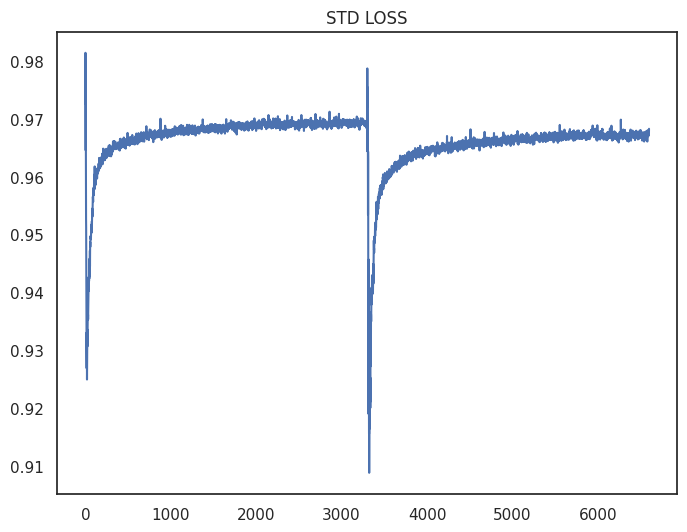

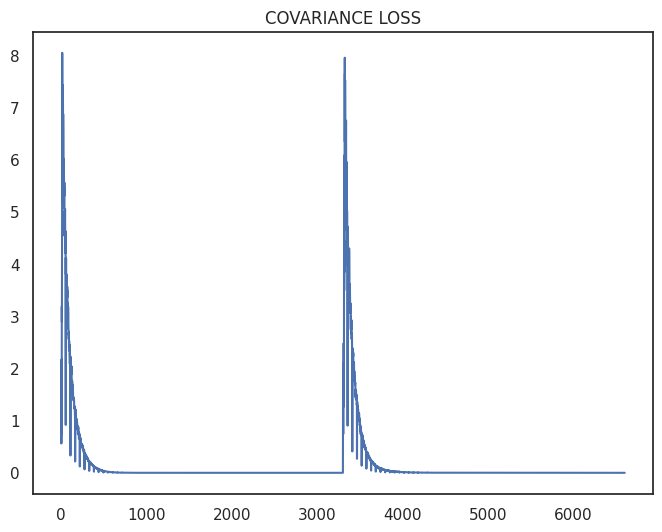

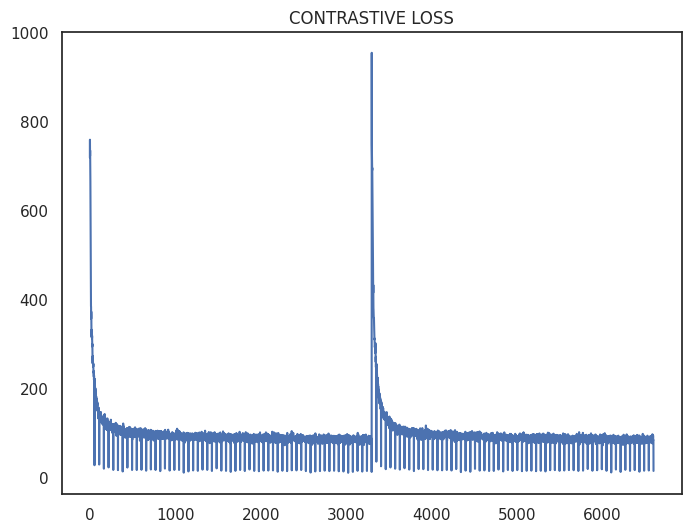

In [41]:
_STD_LOSS = []
for i in range(len(STD_LOSS)):
    _STD_LOSS.append(
        STD_LOSS[i].cpu().detach())
plt.figure(1)
plt.title('STD LOSS')
plt.plot(np.arange(len(STD_LOSS)), _STD_LOSS)

_COVATIANCE_LOSS = []
for i in range(len(COVATIANCE_LOSS)):
    _COVATIANCE_LOSS.append(COVATIANCE_LOSS[i].cpu().detach())
plt.figure(2)  
plt.title('COVARIANCE LOSS')
plt.plot(np.arange(len(COVATIANCE_LOSS)), _COVATIANCE_LOSS)

_CONTRASTIVE_LOSS = []
for i in range(len(CONTRASTIVE_LOSS)):
    _CONTRASTIVE_LOSS.append(CONTRASTIVE_LOSS[i].cpu().detach())
plt.figure(3)  
plt.title('CONTRASTIVE LOSS')
plt.plot(np.arange(len(CONTRASTIVE_LOSS)), _CONTRASTIVE_LOSS)

plt.show()

In [42]:
from ptls.data_load.utils import collate_feature_dict
from ptls.frames.inference_module import InferenceModule
iterable_inference_dataset = ParquetDataset(
    data_files=ParquetFiles(['src/ptls-experiments/scenario_rosbank/data/train_trx.parquet',
                             'src/ptls-experiments/scenario_rosbank/data/test_trx.parquet'],                             
                                                         
                            ).data_files,
    i_filters=[FeatureFilter(['target_flag', 'cl_id'])],
)
next(iter(iterable_inference_dataset))

inference_dl = torch.utils.data.DataLoader(
    dataset=iterable_inference_dataset,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=128,
    num_workers=0,
)
next(iter(inference_dl)).payload

mod = InferenceModule(model, pandas_output=True, model_out_name='emb')

pred = pl.Trainer(gpus=1).predict(mod, inference_dl)

EMBEDDINGS = pd.concat(pred, axis=0)
EMBEDDINGS = EMBEDDINGS.drop(columns='target_flag')

/home/jovyan/conda/ptls/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/conda/ptls/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: : 80it [00:07, 10.08it/s]


In [43]:
EMBEDDINGS.to_pickle('EMBEDDINGS_2.pickle')

In [44]:
EMBEDDINGS

,cl_id,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,10003,-0.000051,0.194493,0.000407,0.011083,-0.000122,-0.000061,0.006140,0.000070,-0.000073,...,-0.000316,-0.038755,0.000565,0.000704,-0.000663,-0.002947,-0.000301,0.000852,1.877106e-06,-0.043322
1,10010,-0.000105,0.389607,0.000067,0.009042,-0.000017,-0.000238,0.011793,0.000050,0.000330,...,-0.000071,-0.054390,0.000137,0.000694,-0.000125,-0.000216,-0.000515,0.000370,2.698090e-04,-0.031784
2,10011,-0.000004,0.521602,0.000097,0.005554,-0.000016,-0.000022,0.000867,0.000041,-0.000450,...,-0.000083,-0.045168,-0.000056,0.000204,-0.000158,-0.000304,-0.000201,0.000081,2.370537e-06,-0.076880
3,10059,-0.000843,0.293336,0.000338,0.001093,0.000414,-0.000218,-0.001710,-0.000288,-0.001290,...,-0.001887,-0.024479,0.000874,0.002150,-0.001987,-0.003515,-0.001730,-0.001231,1.517824e-03,-0.005898
4,10071,-0.000001,0.573548,0.000082,0.006718,-0.000018,-0.000158,-0.003208,0.000455,-0.000128,...,-0.000363,-0.058927,-0.000078,0.001641,-0.000297,-0.000396,-0.000598,0.001019,9.852650e-07,-0.015578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,5712,-0.000040,0.424915,0.000082,0.012020,-0.000064,-0.000057,-0.000269,-0.000001,-0.000128,...,-0.000105,-0.041739,-0.000024,0.000118,-0.000164,-0.000370,-0.000576,0.001075,1.267257e-04,-0.020374
101,7975,-0.000061,0.352384,0.000274,-0.002308,-0.000280,-0.000110,0.000257,-0.000024,0.000583,...,-0.000331,-0.048587,-0.000310,0.005238,-0.000281,-0.001356,-0.001945,0.000307,1.678668e-04,-0.017500
102,8507,-0.000017,0.402696,0.000028,0.008015,-0.000004,-0.000016,0.000256,0.000133,-0.000297,...,-0.000168,-0.049705,-0.000068,0.000527,-0.000099,-0.000144,-0.000184,-0.000025,1.589681e-04,-0.115286
103,8928,-0.000032,0.457478,0.000155,0.009842,-0.000018,-0.000075,-0.000181,0.000059,-0.000208,...,-0.000122,-0.046093,0.000035,0.000406,-0.000312,-0.000431,-0.000616,-0.000228,1.244164e-05,-0.037452


In [45]:
EMBEDDINGS['cl_id'] = EMBEDDINGS['cl_id'].astype('int64')
EMBEDDINGS.to_csv('EMBEDDINGS_2.csv')

In [46]:
# VF = pd.read_pickle('src/ptls-experiments/scenario_rosbank/data/mles_embeddings.pickle')
# VF['emb_0000'] = np.zeros(10217)

In [47]:
# фEMBEDDINGS.to_pickle('VF.pickle')

# <font size="6">Inference</font>

In [48]:
from ptls.data_load.utils import collate_feature_dict
from ptls.frames.inference_module import InferenceModule
iterable_inference_dataset = ParquetDataset(
    data_files=ParquetFiles(['src/ptls-experiments/scenario_rosbank/data/train_trx.parquet/part-00000-5c7d343a-23a3-4a17-a71c-60d3acc4e6f0-c000.snappy.parquet',
                                                         'src/ptls-experiments/scenario_rosbank/data/train_trx.parquet/part-00001-5c7d343a-23a3-4a17-a71c-60d3acc4e6f0-c000.snappy.parquet',
                                                         'src/ptls-experiments/scenario_rosbank/data/train_trx.parquet/part-00002-5c7d343a-23a3-4a17-a71c-60d3acc4e6f0-c000.snappy.parquet',
                                                         'src/ptls-experiments/scenario_rosbank/data/train_trx.parquet/part-00003-5c7d343a-23a3-4a17-a71c-60d3acc4e6f0-c000.snappy.parquet',
                                                         ]).data_files,
    i_filters=[FeatureFilter(['target_flag', 'cl_id'])],
)
next(iter(iterable_inference_dataset))

inference_dl = torch.utils.data.DataLoader(
    dataset=iterable_inference_dataset,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=128,
    num_workers=0,
)
next(iter(inference_dl)).payload

mod = InferenceModule(model, pandas_output=True, model_out_name='emb')

pred = pl.Trainer(gpus=1).predict(mod, inference_dl)

full_predict = pd.concat(pred, axis=0)
full_predict

/home/jovyan/conda/ptls/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/conda/ptls/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: : 36it [00:03, 11.16it/s]


,cl_id,target_flag,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,10018,0.0,-0.001288,0.503811,0.000701,0.006631,0.001967,-0.001124,-0.020712,0.000248,...,-0.000943,-0.032048,-1.029384e-03,0.000293,-0.006195,-0.003518,-0.003134,0.001193,0.000798,-0.016774
1,10030,1.0,-0.000296,0.378138,0.000267,0.008885,-0.000171,-0.000419,0.000018,-0.000057,...,-0.000354,-0.032868,-4.889092e-07,0.000694,-0.000766,-0.001074,-0.001060,0.000799,0.000335,-0.023513
2,10038,0.0,-0.000207,0.391347,0.000374,0.001952,-0.000197,-0.000255,-0.000792,0.000060,...,-0.000095,-0.049294,-7.719045e-05,0.003497,-0.001236,-0.002255,-0.000377,-0.000149,0.000127,-0.036543
3,10057,1.0,-0.000106,0.393228,0.000379,-0.008804,-0.000030,-0.000122,0.000042,0.000050,...,-0.000173,-0.046740,-2.087759e-04,0.000674,-0.000742,-0.000466,-0.000928,0.000381,0.000187,-0.016694
4,10062,1.0,-0.000062,0.311775,0.000130,0.013809,0.000614,-0.000048,0.000108,-0.000049,...,0.000042,-0.036644,2.101777e-06,0.001290,-0.000053,-0.000806,-0.000613,-0.000117,0.000079,-0.054452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,9964,0.0,-0.000180,0.632893,0.000190,0.010873,0.000074,-0.000260,-0.000423,-0.000169,...,-0.000096,-0.039210,2.429149e-04,0.000421,-0.000541,-0.000801,-0.000633,0.000053,0.000181,0.070122
16,9969,1.0,-0.000050,0.308782,0.000019,0.009110,-0.000008,-0.000025,0.001170,-0.000028,...,-0.000090,-0.052611,5.571046e-05,0.000140,-0.000138,-0.000243,-0.000157,0.000042,0.000194,-0.124358
17,997,0.0,-0.000071,0.350800,0.000105,0.002765,-0.000017,-0.000100,-0.000039,-0.000173,...,-0.000263,-0.032821,-5.777816e-05,0.000762,-0.000721,-0.001095,-0.000599,-0.000086,0.000114,-0.011767
18,9973,0.0,-0.000041,0.392164,0.000066,0.007195,-0.000054,-0.000086,0.000646,0.000012,...,-0.000122,-0.056098,4.874341e-05,0.000336,-0.000142,-0.000722,-0.000693,0.000519,0.000083,-0.061912


In [49]:
iterable_inference_dataset_test = ParquetDataset(
    data_files=ParquetFiles('src/ptls-experiments/scenario_rosbank/data/test_trx.parquet').data_files,
    i_filters=[FeatureFilter(['target_flag', 'cl_id'])],
)
next(iter(iterable_inference_dataset_test))

inference_dl_test = torch.utils.data.DataLoader(
    dataset=iterable_inference_dataset_test,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=256,
    num_workers=0,
)
next(iter(inference_dl_test)).payload

pred_test = pl.Trainer(gpus=1).predict(mod, inference_dl_test)
full_predict_test = pd.concat(pred_test, axis=0)
full_predict_test.head()

/home/jovyan/conda/ptls/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/conda/ptls/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: : 2it [00:01,  1.03it/s]


,cl_id,target_flag,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,10155,1.0,-0.000052,0.114725,0.000106,0.014432,-0.000072,-0.000055,0.001525,-0.000134,...,-0.000175,-0.041488,0.000020,0.000598,-0.000215,-0.000557,-0.000435,-0.000412,0.000078,-0.080733
1,2718,1.0,-0.000040,0.563495,0.000083,-0.005009,-0.000018,-0.000026,0.000226,0.002142,...,-0.000199,-0.036342,-0.000053,0.000716,-0.000032,-0.000381,-0.000359,-0.000141,0.000058,-0.032666
2,3656,0.0,-0.000266,0.431028,0.000431,0.005256,0.000320,-0.000285,-0.009656,-0.000286,...,-0.000557,-0.038285,-0.000245,-0.000643,-0.003311,-0.001209,-0.001260,0.002213,0.000023,-0.043321
3,5478,1.0,-0.000006,0.198731,0.000068,-0.000872,-0.000041,-0.000055,0.000256,-0.000109,...,-0.000099,-0.057439,-0.000003,0.000833,-0.000191,-0.001193,-0.000339,0.000351,0.000221,-0.027799
4,5498,1.0,-0.000086,0.286375,0.000377,-0.000199,-0.000048,-0.000124,-0.000260,-0.000071,...,-0.000456,-0.036506,-0.000091,0.001133,-0.000552,-0.001422,-0.000537,0.000111,0.000171,-0.042610


In [50]:
# full_predict.to_csv('EMB_200_train.csv', index=False)
# full_predict_test.to_csv('EMB_200_test.csv', index=False)

In [51]:
# full_predict = pd.read_csv('EMB_200_train.csv')
# full_predict_test = pd.read_csv('EMB_200_test.csv')

agg_data = pd.read_csv('aggs.csv')
agg_data['cl_id'] = agg_data['cl_id'].astype('int64')
full_predict['cl_id'] = full_predict['cl_id'].astype('int64')
full_predict_test['cl_id'] = full_predict_test['cl_id'].astype('int64')

agg_data_train = pd.merge(full_predict, agg_data, on='cl_id')

agg_data_test = pd.merge(full_predict_test, agg_data, on='cl_id')

In [53]:
# x_train, y_train = full_predict.drop(columns=['target_flag']), full_predict['target_flag']
# x_test, y_test = full_predict_test.drop(columns=['target_flag']), full_predict_test['target_flag']
x_train, y_train = agg_data_train.drop(columns=['target_flag', 'cl_id']), agg_data_train['target_flag']
x_test, y_test = agg_data_test.drop(columns=['target_flag', 'cl_id']), agg_data_test['target_flag']


clf = lgb.LGBMClassifier(
    n_estimators=500,
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    subsample=0.5,
    subsample_freq=1,
    learning_rate=0.02,
    feature_fraction=0.75,
    max_depth=6,
    lambda_l1=1,
    lambda_l2=1,
    min_data_in_leaf=50,
    random_state=42,
    n_jobs=8,
    colsample_bytree='null',
    min_child_samples='null'
)

clf.fit(x_train, y_train)

from sklearn.metrics import roc_auc_score
import lightgbm as lgb

y_pred = clf.predict_proba(x_test)[:, 1]

auroc = roc_auc_score(y_test, y_pred)

print(f'AUROC: {auroc}')
print(f'ACC: {clf.score(x_test, y_test)}')

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=null will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=null will be ignored. Current value: min_data_in_leaf=50
AUROC: 0.8469275032563355
ACC: 0.768


**BASELINE SCORE**


**AUROC: 0.8317917264348487**


**ACC: 0.758**

In [62]:
AUROC: 0.8413546355377488
ACC: 0.762

In [18]:
AUROC: 0.8510329590608564
ACC: 0.772

In [230]:
emb_data = pd.read_pickle('src/ptls-experiments/scenario_rosbank/data/mles_embeddings.pickle')
agg_data = pd.read_csv('aggs.csv')

In [231]:
emb_data

,cl_id,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,10003,0.364375,-0.009588,-0.000149,0.001294,0.000279,-0.001702,-0.001505,0.000064,0.000187,...,0.174376,-0.001215,-0.000079,-0.000707,0.025255,-0.000023,5.946040e-05,-0.000089,-0.000086,-0.000051
1,10010,0.598943,0.002875,-0.000053,0.000878,0.000349,-0.000413,-0.000115,0.000017,-0.000015,...,0.355944,-0.000219,0.005621,-0.000197,0.035349,-0.000034,8.490639e-05,-0.000229,-0.000013,-0.000031
2,10011,0.627307,-0.001278,-0.000007,0.000274,0.000290,-0.000087,-0.000394,0.000013,0.000021,...,0.348582,-0.000359,-0.001636,-0.000174,0.035415,-0.000011,-6.282770e-05,-0.000021,-0.000183,-0.000009
3,10059,0.279056,-0.008793,0.000010,0.010386,0.012674,-0.004087,-0.001895,0.000642,0.000451,...,0.034231,0.000270,-0.010681,0.001823,0.021047,-0.000616,1.444836e-05,-0.001307,-0.001205,-0.000798
4,10071,0.638623,0.008252,-0.000032,0.000483,0.001504,-0.000209,-0.000595,0.000034,-0.000054,...,0.155391,-0.000064,0.004765,-0.000029,0.023133,-0.000048,-1.114687e-05,-0.000091,-0.001260,-0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,5712,0.537252,0.000144,-0.000023,0.000055,0.000024,-0.000449,-0.000382,0.000038,0.000045,...,0.058171,-0.000250,0.006965,-0.000116,0.024799,-0.000009,-5.893200e-05,-0.000129,-0.000463,-0.000014
465,7975,0.316654,0.010768,-0.000291,0.001594,0.001906,-0.000472,-0.001635,0.000191,0.000093,...,0.161700,-0.000055,0.001843,0.000110,0.022440,-0.000035,7.271776e-05,-0.000501,-0.000139,-0.000064
466,8507,0.563780,0.005146,0.000012,0.000201,0.000038,-0.000256,-0.000125,0.000039,0.000013,...,0.560283,-0.000144,0.021808,0.000037,0.030075,-0.000039,9.084612e-06,-0.000016,-0.000479,-0.000011
467,8928,0.422701,-0.009045,0.000022,0.000155,0.002257,-0.000241,-0.000970,0.000061,0.000055,...,0.259800,-0.000353,-0.000726,0.000202,0.039669,-0.000096,-1.222512e-05,-0.000174,-0.000749,-0.000034


In [232]:
agg_data

,cl_id,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_0352,emb_0353,emb_0354,emb_0355,emb_0356,emb_0357,emb_0358,emb_0359,emb_0360,emb_0361
0,10003,67.0,351750.900,5250.01370,19958.3850,0.0,0.0,33.0,0.0,1.0,...,0.000,0.0000,0.000,0.00000,0.0,0.0000,24.0,1.0,1.0,1.0
1,10010,109.0,53243.530,488.47278,1487.9280,0.0,0.0,65.0,0.0,2.0,...,0.000,0.0000,0.000,0.00000,0.0,0.0000,20.0,1.0,1.0,1.0
2,10011,133.0,398903.500,2999.27440,8413.3030,0.0,0.0,29.0,5.0,2.0,...,28595.576,0.0000,0.000,0.00000,0.0,19534.5300,25.0,1.0,1.0,3.0
3,10059,12.0,51841.008,4320.08400,5625.0950,0.0,0.0,1.0,0.0,1.0,...,0.000,0.0000,0.000,0.00000,0.0,0.0000,8.0,1.0,1.0,2.0
4,10071,113.0,441330.940,3905.58350,7387.3780,0.0,0.0,17.0,20.0,4.0,...,0.000,0.0000,0.000,0.00000,0.0,212.1320,24.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10212,5712,120.0,975464.400,8128.86960,18873.9860,0.0,0.0,26.0,6.0,5.0,...,19849.432,0.0000,14912.876,0.00000,36557.6,0.0000,17.0,1.0,2.0,6.0
10213,7975,52.0,295692.560,5686.39550,10053.2310,0.0,0.0,3.0,8.0,6.0,...,0.000,0.0000,0.000,0.00000,0.0,0.0000,18.0,1.0,1.0,5.0
10214,8507,206.0,1530374.400,7429.00200,20584.1500,0.0,0.0,59.0,41.0,6.0,...,16464.836,0.0000,0.000,0.00000,0.0,0.0000,28.0,1.0,1.0,5.0
10215,8928,84.0,1472858.900,17534.03500,35396.9100,0.0,0.0,12.0,18.0,4.0,...,57744.953,0.0000,0.000,0.00000,0.0,173.9497,20.0,1.0,1.0,6.0


In [123]:
agg_data['cl_id'] = agg_data['cl_id'].astype('int64')
emb_data['cl_id'] = emb_data['cl_id'].astype('int64')

data = pd.merge(agg_data, emb_data, on='cl_id')

In [124]:
data

,cl_id,emb_0000_x,emb_0001_x,emb_0002_x,emb_0003_x,emb_0004_x,emb_0005_x,emb_0006_x,emb_0007_x,emb_0008_x,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,10003,67.0,351750.900,5250.01370,19958.3850,0.0,0.0,33.0,0.0,1.0,...,0.174376,-0.001215,-0.000079,-0.000707,0.025255,-0.000023,5.946040e-05,-0.000089,-0.000086,-0.000051
1,10010,109.0,53243.530,488.47278,1487.9280,0.0,0.0,65.0,0.0,2.0,...,0.355944,-0.000219,0.005621,-0.000197,0.035349,-0.000034,8.490639e-05,-0.000229,-0.000013,-0.000031
2,10011,133.0,398903.500,2999.27440,8413.3030,0.0,0.0,29.0,5.0,2.0,...,0.348582,-0.000359,-0.001636,-0.000174,0.035415,-0.000011,-6.282770e-05,-0.000021,-0.000183,-0.000009
3,10059,12.0,51841.008,4320.08400,5625.0950,0.0,0.0,1.0,0.0,1.0,...,0.034231,0.000270,-0.010681,0.001823,0.021047,-0.000616,1.444836e-05,-0.001307,-0.001205,-0.000798
4,10071,113.0,441330.940,3905.58350,7387.3780,0.0,0.0,17.0,20.0,4.0,...,0.155391,-0.000064,0.004765,-0.000029,0.023133,-0.000048,-1.114687e-05,-0.000091,-0.001260,-0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10212,5712,120.0,975464.400,8128.86960,18873.9860,0.0,0.0,26.0,6.0,5.0,...,0.058171,-0.000250,0.006965,-0.000116,0.024799,-0.000009,-5.893200e-05,-0.000129,-0.000463,-0.000014
10213,7975,52.0,295692.560,5686.39550,10053.2310,0.0,0.0,3.0,8.0,6.0,...,0.161700,-0.000055,0.001843,0.000110,0.022440,-0.000035,7.271776e-05,-0.000501,-0.000139,-0.000064
10214,8507,206.0,1530374.400,7429.00200,20584.1500,0.0,0.0,59.0,41.0,6.0,...,0.560283,-0.000144,0.021808,0.000037,0.030075,-0.000039,9.084612e-06,-0.000016,-0.000479,-0.000011
10215,8928,84.0,1472858.900,17534.03500,35396.9100,0.0,0.0,12.0,18.0,4.0,...,0.259800,-0.000353,-0.000726,0.000202,0.039669,-0.000096,-1.222512e-05,-0.000174,-0.000749,-0.000034


In [244]:
emb_data = data.iloc[:, 1:363]  
agg_data = data.iloc[:, 363:] 

In [245]:
emb_data

,emb_0000_x,emb_0001_x,emb_0002_x,emb_0003_x,emb_0004_x,emb_0005_x,emb_0006_x,emb_0007_x,emb_0008_x,emb_0009_x,...,emb_0352_x,emb_0353_x,emb_0354_x,emb_0355_x,emb_0356_x,emb_0357_x,emb_0358_x,emb_0359_x,emb_0360_x,emb_0361_x
0,67.0,351750.900,5250.01370,19958.3850,0.0,0.0,33.0,0.0,1.0,1.0,...,0.000,0.0000,0.000,0.00000,0.0,0.0000,24.0,1.0,1.0,1.0
1,109.0,53243.530,488.47278,1487.9280,0.0,0.0,65.0,0.0,2.0,7.0,...,0.000,0.0000,0.000,0.00000,0.0,0.0000,20.0,1.0,1.0,1.0
2,133.0,398903.500,2999.27440,8413.3030,0.0,0.0,29.0,5.0,2.0,0.0,...,28595.576,0.0000,0.000,0.00000,0.0,19534.5300,25.0,1.0,1.0,3.0
3,12.0,51841.008,4320.08400,5625.0950,0.0,0.0,1.0,0.0,1.0,0.0,...,0.000,0.0000,0.000,0.00000,0.0,0.0000,8.0,1.0,1.0,2.0
4,113.0,441330.940,3905.58350,7387.3780,0.0,0.0,17.0,20.0,4.0,0.0,...,0.000,0.0000,0.000,0.00000,0.0,212.1320,24.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10212,120.0,975464.400,8128.86960,18873.9860,0.0,0.0,26.0,6.0,5.0,4.0,...,19849.432,0.0000,14912.876,0.00000,36557.6,0.0000,17.0,1.0,2.0,6.0
10213,52.0,295692.560,5686.39550,10053.2310,0.0,0.0,3.0,8.0,6.0,2.0,...,0.000,0.0000,0.000,0.00000,0.0,0.0000,18.0,1.0,1.0,5.0
10214,206.0,1530374.400,7429.00200,20584.1500,0.0,0.0,59.0,41.0,6.0,21.0,...,16464.836,0.0000,0.000,0.00000,0.0,0.0000,28.0,1.0,1.0,5.0
10215,84.0,1472858.900,17534.03500,35396.9100,0.0,0.0,12.0,18.0,4.0,1.0,...,57744.953,0.0000,0.000,0.00000,0.0,173.9497,20.0,1.0,1.0,6.0


In [246]:
agg_data

,emb_0000_y,emb_0001_y,emb_0002_y,emb_0003_y,emb_0004_y,emb_0005_y,emb_0006_y,emb_0007_y,emb_0008_y,emb_0009_y,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,0.364375,-0.009588,-0.000149,0.001294,0.000279,-0.001702,-0.001505,0.000064,0.000187,-0.000348,...,0.174376,-0.001215,-0.000079,-0.000707,0.025255,-0.000023,5.946040e-05,-0.000089,-0.000086,-0.000051
1,0.598943,0.002875,-0.000053,0.000878,0.000349,-0.000413,-0.000115,0.000017,-0.000015,-0.000074,...,0.355944,-0.000219,0.005621,-0.000197,0.035349,-0.000034,8.490639e-05,-0.000229,-0.000013,-0.000031
2,0.627307,-0.001278,-0.000007,0.000274,0.000290,-0.000087,-0.000394,0.000013,0.000021,-0.000129,...,0.348582,-0.000359,-0.001636,-0.000174,0.035415,-0.000011,-6.282770e-05,-0.000021,-0.000183,-0.000009
3,0.279056,-0.008793,0.000010,0.010386,0.012674,-0.004087,-0.001895,0.000642,0.000451,0.001483,...,0.034231,0.000270,-0.010681,0.001823,0.021047,-0.000616,1.444836e-05,-0.001307,-0.001205,-0.000798
4,0.638623,0.008252,-0.000032,0.000483,0.001504,-0.000209,-0.000595,0.000034,-0.000054,0.000056,...,0.155391,-0.000064,0.004765,-0.000029,0.023133,-0.000048,-1.114687e-05,-0.000091,-0.001260,-0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10212,0.537252,0.000144,-0.000023,0.000055,0.000024,-0.000449,-0.000382,0.000038,0.000045,0.000342,...,0.058171,-0.000250,0.006965,-0.000116,0.024799,-0.000009,-5.893200e-05,-0.000129,-0.000463,-0.000014
10213,0.316654,0.010768,-0.000291,0.001594,0.001906,-0.000472,-0.001635,0.000191,0.000093,0.000033,...,0.161700,-0.000055,0.001843,0.000110,0.022440,-0.000035,7.271776e-05,-0.000501,-0.000139,-0.000064
10214,0.563780,0.005146,0.000012,0.000201,0.000038,-0.000256,-0.000125,0.000039,0.000013,0.000094,...,0.560283,-0.000144,0.021808,0.000037,0.030075,-0.000039,9.084612e-06,-0.000016,-0.000479,-0.000011
10215,0.422701,-0.009045,0.000022,0.000155,0.002257,-0.000241,-0.000970,0.000061,0.000055,0.000195,...,0.259800,-0.000353,-0.000726,0.000202,0.039669,-0.000096,-1.222512e-05,-0.000174,-0.000749,-0.000034


In [262]:
EMB = torch.tensor(emb_data.values, dtype=torch.float32)
AGG = F.normalize(torch.tensor(agg_data.values, dtype=torch.float32))

In [24]:
# ones = torch.ones(EMB.shape)
ones = torch.randperm(EMB.size()[0])
ones = EMB[ones]

cov_aggs_embs = (AGG.T @ ones) / 10217
cov_loss = cov_aggs_embs.pow_(2).sum() / ((1024 + 362) / 2)
cov_loss

NameError: name 'EMB' is not defined

In [263]:
cov_aggs_embs = (AGG.T @ EMB) / 10217
cov_loss = cov_aggs_embs.pow_(2).sum() / ((1024 + 362) / 2)

In [264]:
cov_loss

tensor(3.4120e+08)